Setup

In [2]:
### Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_ubyte, feature

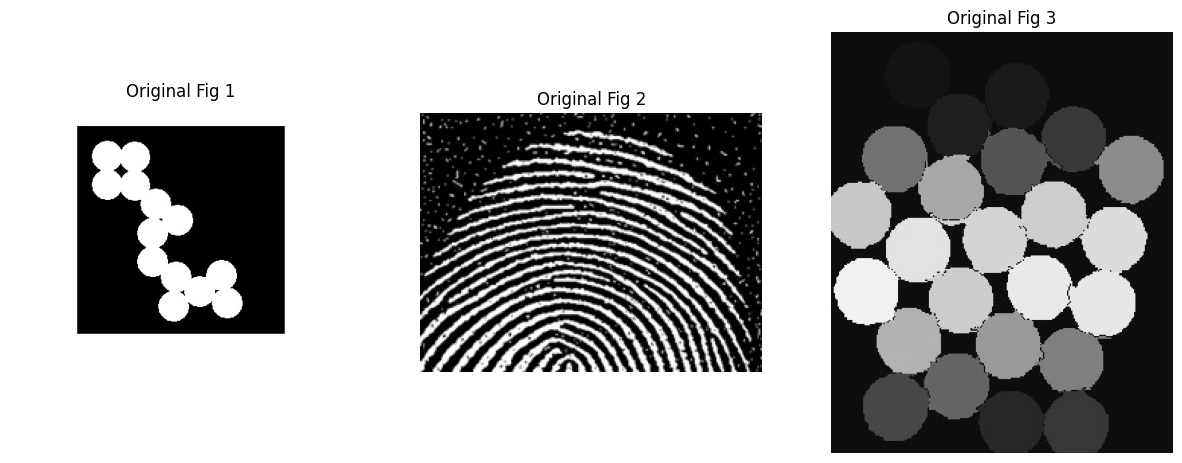

In [3]:
# Function to display images
def display_images(images, titles, rows=1, cols=3):
    """Display multiple images in a grid layout."""
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

base_path = r'C:\Users\danis\OneDrive\Documents\Repos\CV_PE2\Practicals\P3_\data'

# Load images for the tasks
fig1 = cv2.imread( rf"{base_path}\fig1.jpg", 0)  # Replace with the path to Fig 1
fig2 = cv2.imread( rf"{base_path}\fig2.jpg", 0)  # Replace with the path to Fig 1
fig3 = cv2.imread( rf"{base_path}\fig3.jpg", 0)  # Replace with the path to Fig 1

# Display original images
display_images([fig1, fig2, fig3], ['Original Fig 1', 'Original Fig 2', 'Original Fig 3'])

Task 1: Erode and Count Balls

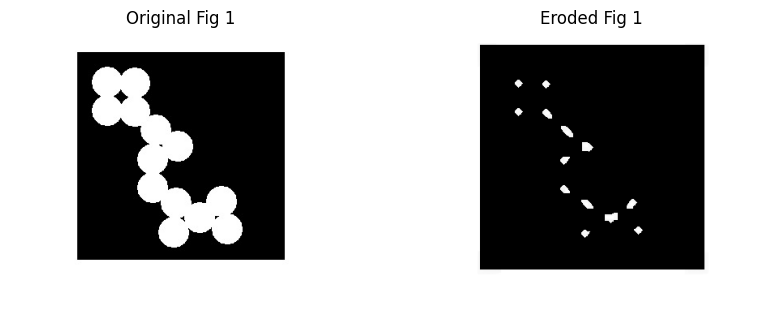

Total number of balls in Fig 1: 14


In [4]:

# Lab Task 1: Perform Erosion to separate balls in Fig 1
def task1_erosion(image, kernel_size=8):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded = cv2.erode(image, kernel, iterations=3)
    return eroded


# Optional: Count objects in the eroded image (Lab Task 1 extension)
def count_objects(eroded_image):
    _, thresh = cv2.threshold(eroded_image, 127, 255, cv2.THRESH_BINARY)
    num_labels, _ = cv2.connectedComponents(thresh)
    return num_labels - 1  # Subtract 1 for the background



# Perform operations for Lab Tasks
eroded_fig1 = task1_erosion(fig1)

# Display results
display_images([fig1, eroded_fig1], ['Original Fig 1', 'Eroded Fig 1'])
# Count objects in Fig 1 after erosion
num_balls = count_objects(eroded_fig1)
print(f"Total number of balls in Fig 1: {num_balls}")



Task 2: Fingerprint

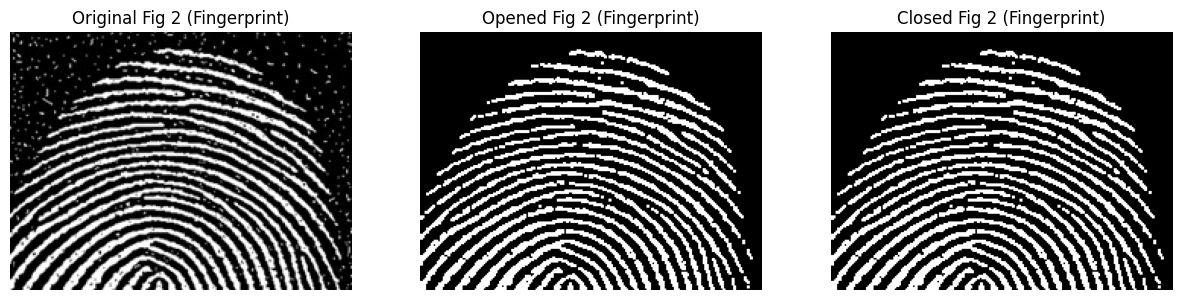

In [13]:
# Convert to binary image (if it's not already binary)
_, binary_fig2 = cv2.threshold(fig2, 127, 255, cv2.THRESH_BINARY)

# Define a 3x3 kernel for morphological operations
kernel1 = np.ones((2, 2), np.uint8)
kernel2 = np.ones((1, 1), np.uint8)

# Apply Morphological Opening to remove noise (small points)
opened_fig2 = cv2.morphologyEx(binary_fig2, cv2.MORPH_OPEN, kernel1)

# Apply Morphological Closing to fill gaps between ridges (or thumb impressions)
closed_fig2 = cv2.morphologyEx(opened_fig2, cv2.MORPH_CLOSE, kernel2)


# Display the images: Original, Opened, and Closed
display_images([fig2, opened_fig2, closed_fig2], ['Original Fig 2 (Fingerprint)', 'Opened Fig 2 (Fingerprint)', 'Closed Fig 2 (Fingerprint)'])

Morphological Gradient

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to count the number of balls in the binary image
def count_balls(binary_image):
    # Count contours in the binary image (approach for ball counting)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return len(contours)

# Step 1: Preprocessing - Enhance contrast
fig3_eq = cv2.equalizeHist(fig3)  # Equalize the histogram for better contrast

# Step 2: Apply Gaussian Blur to reduce noise
fig3_blurred = cv2.GaussianBlur(fig3_eq, (5, 5), 0)

# Step 3: Use Adaptive Thresholding to handle varying lighting
binary_fig3 = cv2.adaptiveThreshold(fig3_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY, 11, 2)

# Count balls after thresholding
binary_ball_count = count_balls(binary_fig3)
print(f"Ball count after thresholding: {binary_ball_count}")

# Step 4: Apply erosion to separate balls that are too close
kernel = np.ones((3, 3), np.uint8)
eroded_fig3 = cv2.erode(binary_fig3, kernel, iterations=1)

# Count balls after erosion
eroded_ball_count = count_balls(eroded_fig3)
print(f"Ball count after erosion: {eroded_ball_count}")

# Step 5: Apply dilation to restore the size of the balls
dilated_fig3 = cv2.dilate(eroded_fig3, kernel, iterations=1)

# Count balls after dilation
dilated_ball_count = count_balls(dilated_fig3)
print(f"Ball count after dilation: {dilated_ball_count}")

# Step 6: Distance Transform to help separate close balls
dist_transform = cv2.distanceTransform(binary_fig3, cv2.DIST_L2, 5)

# Adjusting threshold to allow better separation of balls
_, dist_transform_thresh = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)

# Count balls after distance transform thresholding
dist_transform_ball_count = count_balls(dist_transform_thresh)
print(f"Ball count after distance transform thresholding: {dist_transform_ball_count}")

# Step 7: Apply watershed algorithm to separate connected objects
# Find sure background area (dilate the binary image further)
sure_bg = cv2.dilate(binary_fig3, kernel, iterations=3)

# Find sure foreground area using the distance transform
sure_fg = np.uint8(dist_transform_thresh)

# Subtract sure foreground from sure background to get the unknown region
unknown = cv2.subtract(sure_bg, sure_fg)

# Step 8: Label markers for the watershed algorithm (use connected components)
_, markers = cv2.connectedComponents(sure_fg)

# Mark the unknown region as 0 (important for watershed to distinguish)
markers[unknown == 255] = 0

# Convert the grayscale image to BGR format for the watershed algorithm
fig3_bgr = cv2.cvtColor(fig3, cv2.COLOR_GRAY2BGR)

# Apply watershed algorithm
try:
    markers = cv2.watershed(fig3_bgr, markers)
except cv2.error as e:
    raise ValueError(f"Watershed algorithm failed: {e}")

# Step 9: Mark boundaries with red on the original image
# Correctly marking boundaries on the BGR image (edges between balls)
fig3_bgr[markers == -1] = [255, 0, 0]

# Count balls after watershed segmentation
watershed_ball_count = count_balls(markers)
print(f"Ball count after watershed segmentation: {watershed_ball_count}")

# Step 10: Refine boundaries (optional but may help)
# We can add some post-processing here to further clean up the watershed result.

# Step 11: Visualize the output
# Create a color map for labeled balls
unique_markers = np.unique(markers)
num_balls = len(unique_markers) - 1  # Subtract 1 to exclude the background
colored_markers = np.uint8(markers * (255 / num_balls))
output_image = cv2.applyColorMap(colored_markers, cv2.COLORMAP_JET)

# Display all images
def display_images(images, titles):
    plt.figure(figsize=(15, 10))
    num_images = len(images)
    rows = (num_images // 3) + (num_images % 3 != 0)  # Dynamic rows calculation
    cols = 3  # 3 columns per row
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap='gray' if len(images[i].shape) == 2 else None)
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Display images
display_images(
    [binary_fig3, eroded_fig3, dilated_fig3, dist_transform, fig3_bgr, output_image],
    [
        'Binary Image', 'Eroded Image', 'Dilated Image', 
        'Distance Transform', 'Watershed Result', 'Labeled Balls'
    ]
)

# Print the number of balls detected
print(f"Number of balls detected: {num_balls}")


Ball count after thresholding: 21
Ball count after erosion: 40
Ball count after dilation: 19


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\contours_new.cpp:330: error: (-2:Unspecified error) in function 'class std::shared_ptr<struct ContourScanner_> __cdecl ContourScanner_::create(class cv::Mat,int,int,class cv::Point_<int>)'
> Modes other than RETR_FLOODFILL and RETR_CCOMP support only CV_8UC1 images (expected: 'img.type() == CV_8UC1'), where
>     'img.type()' is 5 (CV_32FC1)
> must be equal to
>     'CV_8UC1' is 0 (CV_8UC1)
